# From Theory to Practice: Unlocking the Distribution of Capacitive Times for Electrochemical Impedance Spectroscopy

In this tutorial, we will show how two use the two deep neural networks (DNNs) described in the article to analyze an artifical EIS spectrum generated using the series association of a double ZARC element and a generalized Warburg element (Section 3.2.1.1).

In [1]:
# import the libraries needed
import os
import numpy as np
import importlib
import compute_DCT
importlib.reload(compute_DCT)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# additional verifications
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# check the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,3), 'MB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**2,3), 'MB')
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# seed for reproducibility
torch.manual_seed(213912)

Using device: cpu


In [3]:
# plot standards
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# 1. Generate the artificial data

## 1.1 Define the ranges of EIS frequencies and timescales

In [4]:
# range of frequencies
N_freqs = 91
freq_min = 10**-3 # Hz
freq_max = 10**6 # Hz
freq_vec = np.logspace(np.log10(freq_min), np.log10(freq_max), num=N_freqs, endpoint=True)
freq_vec_torch = torch.from_numpy(freq_vec[:, np.newaxis]).type(Tensor)
omega_vec = 2.*np.pi*freq_vec

# range of timescales
N_taus = 161
tau_vec = np.logspace(-6, 2, num = N_taus, endpoint=True)
log_tau_vec = np.log(tau_vec.reshape(N_taus,1))
log_tau_vec_norm = -1.+2.*(log_tau_vec-log_tau_vec.min())/(log_tau_vec.max()-log_tau_vec.min())

## 1.2 Set the values of the circuit parameters

In [5]:
R_inf = 10 # Ohm
R_ct_1 = 2.5 # Ohm
phi_1 = 0.8 # unitless
tau_1 = 10**(-5) # s
R_ct_2 = 10 # Ohm
phi_2 = 0.8 # unitless
tau_2 = 10**(-1) # s
A = 10 # Ohm.s^(-alpha)
alpha = 0.6 # unitless

## 1.3 Define the exact and experimental impedances (see (20a) in the article)

In [6]:
# experimental data
N_exp = 1 # one artificial EIS spectrum

# exact impedance of the double ZARC + generalize Warburg association
Z_exact = R_inf + R_ct_1/(1.0+((1j*omega_vec*tau_1)**phi_1)) + R_ct_2/(1.0+((1j*omega_vec*tau_2)**phi_2)) + A/((omega_vec*1j)**alpha)

# exact admittance of the double ZARC + generalize Warburg association
Y_exact = 1/Z_exact

# artificial impedances
Z_exp_list = [0]*N_exp # list of experimental impedances

rng = np.random.seed(12129)
sigma_n_exp = 0.025 # standard deviation of the experimental noise

for n in range(N_exp):
    Z_exp_list[n] = Z_exact + sigma_n_exp*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

## 1.4 Define the exact DCT (see (20b) in the article)

In [7]:
def gamma_DCT_exact_fct(tau_vec, R_inf, R_ct_1, tau_1, phi_1, R_ct_2, tau_2, phi_2, A, alpha):
    
    x_1 = (tau_vec/tau_1)**phi_1
    denom_1 = 1 + 2*np.cos(np.pi*phi_1)*x_1 + x_1**2
    num_1 = R_ct_1*x_1*np.sin(np.pi*phi_1)/denom_1
    
    x_2 = (tau_vec/tau_2)**phi_2
    denom_2 = 1 + 2*np.cos(np.pi*phi_2)*x_2 + x_2**2
    num_2 = R_ct_2*x_2*np.sin(np.pi*phi_2)/denom_2
    
    num = num_1 + num_2 + A*np.sin(np.pi*alpha)*tau_vec**alpha
    
    y_1 = R_ct_1*x_1*(np.cos(np.pi*phi_1)+x_1)/denom_1
    y_2 = R_ct_2*x_2*(np.cos(np.pi*phi_2)+x_2)/denom_2
    
    denom_0 = R_inf + y_1 + y_2 + A*np.cos(np.pi*alpha)*tau_vec**alpha
    
    denom = denom_0**2 + num**2
    
    out_gamma_DCT = 1/np.pi*num/denom
    
    return out_gamma_DCT

gamma_DCT_exact = gamma_DCT_exact_fct(tau_vec, R_inf, R_ct_1, tau_1, phi_1, R_ct_2, tau_2, phi_2, A, alpha)

# 2. Ridge regression (RR) to pretrain the DNNs

## 2.1 Example of RR for one EIS spectrum

In [8]:
# discretization matrices for the admittance
A_re_G_inf = np.ones((N_freqs, 1))
A_im_G_inf = np.zeros((N_freqs, 1))
A_re_C_0 = np.zeros((N_freqs, 1))
A_im_C_0 = 2*np.pi*freq_vec.reshape((N_freqs, 1))
A_re_YY = compute_DCT.A_re_ad(freq_vec, tau_vec)
A_im_YY = compute_DCT.A_im_ad(freq_vec, tau_vec)
A_re_Y = np.hstack(( A_re_G_inf, A_re_C_0, A_re_YY))
A_im_Y = np.hstack(( A_im_G_inf, A_im_C_0, A_im_YY))
A_Y = np.vstack((A_re_Y, A_im_Y))

# second-order differentiation matrix
M_Y = np.zeros((N_taus+2, N_taus+2))
M_Y[2:, 2:] = compute_DCT.compute_M_D2(tau_vec)

# regularization parameter
lambda0 = 10**(-3)

# DCT and admittance from ridge regression (RR)
x_RR, gamma_DCT_RR, G_inf_RR, C_0_RR = compute_DCT.Simple_run(Z_exp_list[0], freq_vec, tau_vec, A_re_Y, A_im_Y, M_Y, lambda0)
Y_RR = A_Y@x_RR
Y_RR = Y_RR[0:N_freqs] + 1j*Y_RR[N_freqs:] 

     pcost       dcost       gap    pres   dres
 0: -4.3131e-01 -1.2546e+00  2e+02  1e+01  1e-04
 1:  5.9367e-01 -3.4412e+00  5e+01  3e+00  3e-05
 2:  7.0846e-01 -2.7624e+00  2e+01  8e-01  7e-06
 3:  6.0569e-02 -1.6980e+00  2e+00  8e-03  7e-08
 4: -3.8775e-01 -6.2118e-01  2e-01  8e-05  7e-10
 5: -4.2418e-01 -4.6258e-01  4e-02  1e-05  9e-11
 6: -4.3018e-01 -4.4020e-01  1e-02  2e-06  2e-11
 7: -4.3140e-01 -4.3268e-01  1e-03  8e-08  7e-13
 8: -4.3154e-01 -4.3175e-01  2e-04  1e-08  8e-14
 9: -4.3156e-01 -4.3159e-01  3e-05  6e-10  6e-15
10: -4.3156e-01 -4.3157e-01  2e-06  4e-11  3e-16
11: -4.3156e-01 -4.3156e-01  3e-07  3e-12  1e-16
12: -4.3156e-01 -4.3156e-01  2e-08  7e-14  1e-16
13: -4.3156e-01 -4.3156e-01  4e-09  1e-14  2e-16
14: -4.3156e-01 -4.3156e-01  5e-10  6e-16  1e-16
15: -4.3156e-01 -4.3156e-01  6e-12  2e-17  5e-17
Optimal solution found.


## 2.2 Plot of the exact and RR-regressed DCTs

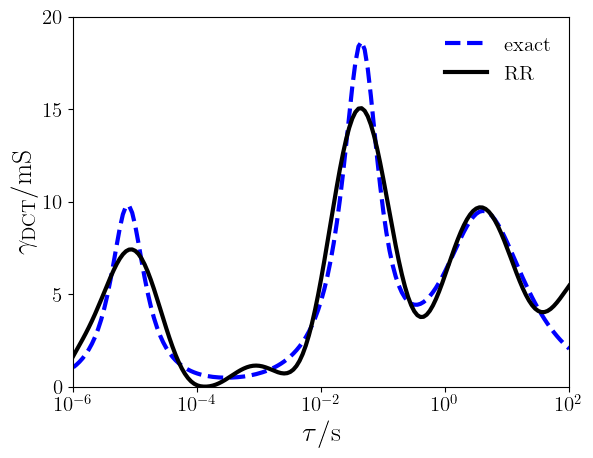

In [9]:
# DCT from RR
plt.semilogx(tau_vec, gamma_DCT_exact*1000, '--', linewidth=3, color='blue', label='exact')
plt.semilogx(tau_vec, gamma_DCT_RR*1000, linewidth=3, color='black', label='RR')

plt.xlim(1E-6, 1E2)
plt.ylim(0, 20)
plt.yticks(np.arange(0, 20.001, 5))
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$\tau/\rm s$', fontsize = 20) 
plt.ylabel(r'$\gamma_{\rm DCT}/\rm mS$', fontsize = 20)
plt.show()

## 2.3 Nyquist plot of the experimental, exact, and RR-regressed admittances

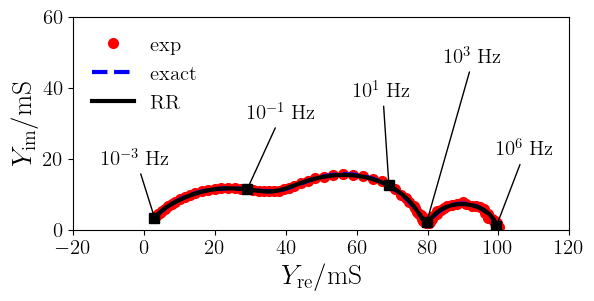

In [10]:
Y_exp = 1/Z_exp_list[0]
Y_exact = 1/Z_exact

# Nyquist plot of the admittances
plt.plot(np.real(Y_exp*1000), np.imag(Y_exp*1000), 'o', markersize=7, color='red', label='exp')
plt.plot(np.real(Y_exact*1000), np.imag(Y_exact*1000), '--', linewidth=3, color='blue', label='exact')
plt.plot(np.real(Y_RR*1000), np.imag(Y_RR*1000), linewidth=3, color='black', label='RR')
plt.plot(np.real(Y_exp[0]*1000), np.imag(Y_exp[0]*1000), 's', markersize=7, color='black')
plt.plot(np.real(Y_exp[20]*1000), np.imag(Y_exp[20]*1000), 's', markersize=7, color='black')
plt.plot(np.real(Y_exp[40]*1000), np.imag(Y_exp[40]*1000), 's', markersize=7, color='black')
plt.plot(np.real(Y_exp[60]*1000), np.imag(Y_exp[60]*1000), 's', markersize=7, color='black')
plt.plot(np.real(Y_exp[90]*1000), np.imag(Y_exp[90]*1000), 's', markersize=7, color='black')

plt.annotate(r'$10^{-3} \; \rm{Hz}$', xy=(np.real(Y_exp[0]*1000), np.imag(Y_exp[0]*1000)), 
                 xytext=(np.real(Y_exp[0]*1000)-15, 15+np.imag(Y_exp[0]*1000)), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{-1} \; \rm{Hz}$', xy=(np.real(Y_exp[20]*1000), np.imag(Y_exp[20]*1000)), 
                 xytext=(np.real(Y_exp[20]*1000), 20+np.imag(Y_exp[20]*1000)), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{1} \; \rm{Hz}$', xy=(np.real(Y_exp[40]*1000), np.imag(Y_exp[40]*1000)), 
                 xytext=(np.real(Y_exp[40]*1000)-10, 25+np.imag(Y_exp[40]*1000)), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{3} \; \rm{Hz}$', xy=(np.real(Y_exp[60]*1000), np.imag(Y_exp[60]*1000)), 
                 xytext=(np.real(Y_exp[60]*1000)+5, 45+np.imag(Y_exp[60]*1000)), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{6} \; \rm{Hz}$', xy=(np.real(Y_exp[90]*1000), np.imag(Y_exp[90]*1000)), 
                 xytext=(np.real(Y_exp[90]*1000), 20+np.imag(Y_exp[90]*1000)), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))

plt.axis('scaled')
plt.xlim(-20, 120)
plt.ylim(0, 60)
plt.legend(frameon=False, fontsize = 15, loc='upper left')
plt.xlabel(r'$Y_{\rm re}/\rm mS$', fontsize = 20)
plt.ylabel(r'$Y_{\rm im}/\rm mS$', fontsize = 20)
plt.show()

# 3. Deep neural networks (DNNs)

## 3.1 Define the inputs of the DNNs

In [11]:
# define the reference conductance value, which acts as base
C_ref = 1E-5 
freq_times_Cref_torch = freq_vec_torch*C_ref

# list of experimental states, e.g., the temperature
T_min = 1
T_max = 2
delta_T = 1
T_range = np.arange(T_min, T_max, delta_T)

if T_min == T_max:
    T_range_norm = np.array([0.0])
else:
    T_range_norm = (T_range-T_min)/(T_max-T_min)

N_temps = len(T_range)

# lists of admittances and DCTs
Y_re_list, Y_im_list = [], []
YC_RR_list, gamma_RR_list = [], []

input_YC_NN = np.array([], dtype=np.float64).reshape(0, 1)
input_gamma_NN = np.array([], dtype=np.float64).reshape(0, 2)

for index, temp in enumerate(T_range):
    
    # experimental admittances
    Z_exp = Z_exp_list[index]
    Y_exp = 1/Z_exp
    Y_re = np.real(Y_exp)
    Y_im = np.imag(Y_exp)
    
    # convert the experimental and RR-regressed admittances to torch
    Y_re_torch = torch.from_numpy(Y_re.reshape(N_freqs,1)).type(Tensor)
    Y_im_torch = torch.from_numpy(Y_im.reshape(N_freqs,1)).type(Tensor)
    Y_re_list.append(Y_re_torch.detach())
    Y_im_list.append(Y_im_torch.detach())
    
    # prepare the pretraining step
    x_RR, gamma_RR, G_inf_RR, C_0_RR = compute_DCT.Simple_run(Z_exp, freq_vec, tau_vec, A_re_Y, A_im_Y, M_Y, lambda0)
    Y_RR = A_Y@x_RR
    Y_RR = Y_RR[0:N_freqs] + 1j*Y_RR[N_freqs:] 

    # convert to torch the conductance, G_inf_RR, and capacitance, C_0_RR, regressed with RR, and then save them in a list
    YC_RR_vec = torch.from_numpy(np.asarray([G_inf_RR, C_0_RR])).type(Tensor)
    YC_RR_list.append(YC_RR_vec.detach())
    
    # convert the DCT from RR in list storage
    gamma_RR_list.append(torch.from_numpy(gamma_RR.reshape(N_taus,1)).type(Tensor))
      
    # input for the GC-DNN that returns G_inf and C_0
    temp_loc = T_range_norm[index]
    input_YC_NN = np.vstack((input_YC_NN, temp_loc))
    
    # inputs for the gamma_DCT-DNN that returns the DCT
    temp_vec_loc = temp_loc*np.ones_like(log_tau_vec_norm)
    input_loc = np.hstack((temp_vec_loc, log_tau_vec_norm))
    input_gamma_NN = np.vstack((input_gamma_NN, input_loc))
    
    # data used in NN
    input_YC_NN_torch = torch.from_numpy(input_YC_NN).type(Tensor)
    input_gamma_NN_torch = torch.from_numpy(input_gamma_NN).type(Tensor)

     pcost       dcost       gap    pres   dres
 0: -4.3131e-01 -1.2546e+00  2e+02  1e+01  1e-04
 1:  5.9367e-01 -3.4412e+00  5e+01  3e+00  3e-05
 2:  7.0846e-01 -2.7624e+00  2e+01  8e-01  7e-06
 3:  6.0569e-02 -1.6980e+00  2e+00  8e-03  7e-08
 4: -3.8775e-01 -6.2118e-01  2e-01  8e-05  7e-10
 5: -4.2418e-01 -4.6258e-01  4e-02  1e-05  9e-11
 6: -4.3018e-01 -4.4020e-01  1e-02  2e-06  2e-11
 7: -4.3140e-01 -4.3268e-01  1e-03  8e-08  7e-13
 8: -4.3154e-01 -4.3175e-01  2e-04  1e-08  8e-14
 9: -4.3156e-01 -4.3159e-01  3e-05  6e-10  6e-15
10: -4.3156e-01 -4.3157e-01  2e-06  4e-11  3e-16
11: -4.3156e-01 -4.3156e-01  3e-07  3e-12  1e-16
12: -4.3156e-01 -4.3156e-01  2e-08  7e-14  1e-16
13: -4.3156e-01 -4.3156e-01  4e-09  1e-14  2e-16
14: -4.3156e-01 -4.3156e-01  5e-10  6e-16  1e-16
15: -4.3156e-01 -4.3156e-01  6e-12  2e-17  5e-17
Optimal solution found.


## 3.2 Discretization and differentiation matrices

In [12]:
# discretization matrices
A_re_matrix = compute_DCT.A_re_ad(freq_vec, tau_vec)
A_im_matrix = compute_DCT.A_im_ad(freq_vec, tau_vec)

# differentiation matrix
L_matrix = compute_DCT.L(tau_vec)

# convert the matrices to torch
A_re_torch = torch.from_numpy(A_re_matrix).type(Tensor)
A_im_torch = torch.from_numpy(A_im_matrix).type(Tensor)
L_torch = torch.from_numpy(L_matrix).type(Tensor)

## 3.3 Define the parameters

In [13]:
# D_in is input dimension, H is the hidden dimension, D_out is output dimension
N_zeta = 0
D_in_gamma = 2 + N_zeta # this corresponds to tau and the temperature
D_in_YC = 1 # this corresponds to the temperature only
H_gamma = 50
H_YC = 10
D_out_gamma = 1
D_out_YC = 2

## 3.4 Architecture of the two DNNs

In [14]:
# architecture of the GC-DNN
class YC_NN(torch.nn.Module):
    def __init__(self):
        
        super(YC_NN, self).__init__()
        self.fct_1 = torch.nn.Linear(D_in_YC, H_YC)
        self.fct_2 = torch.nn.Linear(H_YC, H_YC)
        self.fct_3 = torch.nn.Linear(H_YC, H_YC)
        self.fct_4 = torch.nn.Linear(H_YC, H_YC)
        self.fct_5 = torch.nn.Linear(H_YC, D_out_YC)

        torch.nn.init.xavier_normal_(self.fct_1.weight)
        torch.nn.init.xavier_normal_(self.fct_2.weight)
        torch.nn.init.xavier_normal_(self.fct_3.weight)
        torch.nn.init.xavier_normal_(self.fct_4.weight)
        torch.nn.init.xavier_normal_(self.fct_5.weight)

        torch.nn.init.zeros_(self.fct_1.bias)
        torch.nn.init.zeros_(self.fct_2.bias)
        torch.nn.init.zeros_(self.fct_3.bias)
        torch.nn.init.zeros_(self.fct_4.bias)
        torch.nn.init.zeros_(self.fct_5.bias)

    def forward(self, freq):

        x = F.elu(self.fct_1(freq))
        x = F.elu(self.fct_2(x))
        x = F.elu(self.fct_3(x))
        x = F.elu(self.fct_4(x))
        gamma = F.softplus(self.fct_5(x))        
        
        return gamma

# architecture of the gamma_DCT-DNN
class gamma_NN(torch.nn.Module):
    def __init__(self):
        
        super(gamma_NN, self).__init__()
        self.fct_1 = torch.nn.Linear(D_in_gamma, H_gamma)
        self.fct_2 = torch.nn.Linear(H_gamma, H_gamma)
        self.fct_3 = torch.nn.Linear(H_gamma, H_gamma)
        self.fct_4 = torch.nn.Linear(H_gamma, H_gamma)
        self.fct_5 = torch.nn.Linear(H_gamma, D_out_gamma)

        torch.nn.init.xavier_normal_(self.fct_1.weight)
        torch.nn.init.xavier_normal_(self.fct_2.weight)
        torch.nn.init.xavier_normal_(self.fct_3.weight)
        torch.nn.init.xavier_normal_(self.fct_4.weight)
        torch.nn.init.xavier_normal_(self.fct_5.weight)

        torch.nn.init.zeros_(self.fct_1.bias)
        torch.nn.init.zeros_(self.fct_2.bias)
        torch.nn.init.zeros_(self.fct_3.bias)
        torch.nn.init.zeros_(self.fct_4.bias)
        torch.nn.init.zeros_(self.fct_5.bias)

    def forward(self, freq):

        x = F.elu(self.fct_1(freq))
        x = F.elu(self.fct_2(x))
        x = F.elu(self.fct_3(x))
        x = F.elu(self.fct_4(x))
        gamma = F.softplus(self.fct_5(x))        
        
        return gamma

## 3.5 Loss function defined in (29)

In [15]:
def loss_fn(YC_NN_output, gamma_NN_output, YC_RR_list, gamma_RR_list, Y_re_list, Y_im_list):
    
    loss, MSE_Z = 0, 0
    
    for index in range(len(T_range)):
        
        # unpack the neural network output
        G_inf = YC_NN_output[index, 0]
        C_0 = YC_NN_output[index, 1]
        G_inf_RR = YC_RR_list[index][0]
        C_0_RR = YC_RR_list[index][1]/C_ref
        
        # unpack gamma
        index_unpack = range(index*N_taus, (index+1)*N_taus)
        gamma = gamma_NN_output[index_unpack,0].reshape(N_taus,1)

        # external data
        Y_re = Y_re_list[index]
        Y_im = Y_im_list[index]
                
        MSE_re = torch.sum((G_inf + torch.matmul(A_re_torch, gamma) - Y_re)**2)
        MSE_im = torch.sum((2.*np.pi*freq_times_Cref_torch*C_0 + torch.matmul(A_im_torch, gamma) - Y_im)**2)
        MSE_YC = torch.sum((torch.hstack((G_inf_RR, C_0_RR)) - YC_NN_output[index])**2)
        MSE_gamma = torch.sum((gamma - gamma_RR_list[index])**2)
        MSE_Z += MSE_re + MSE_im
        loss += MSE_re + MSE_im + MSE_gamma + MSE_YC
    
    return loss, MSE_Z

model_gamma = gamma_NN()
model_YC = YC_NN()
if cuda:
    model_gamma.cuda()
    model_YC.cuda()

## 3.6 Training of the DNNs

In [16]:
# we use Adam algorithm with a learning rate of 10**(-5)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model_gamma.parameters(), lr=learning_rate)
optimizer.add_param_group({"params": model_YC.parameters()})

# maximum number of iterations
max_iters = 100001

# optimize the neural network
loss_vec = []

gamma_NN_store = torch.zeros((max_iters, N_taus, N_temps)).type(Tensor)
G_inf_NN_store = torch.zeros((max_iters, N_temps)).type(Tensor)
C_0_NN_store = torch.zeros((max_iters, N_temps)).type(Tensor)

for t in range(max_iters):
    
    # forward pass: compute predicted y by passing x to the model
    gamma_NN_output = model_gamma(input_gamma_NN_torch)
    YC_NN_output = model_YC(input_YC_NN_torch)
    
    # compute the loss
    loss, MSE = loss_fn(YC_NN_output, gamma_NN_output, YC_RR_list, gamma_RR_list, Y_re_list, Y_im_list)
    
    # save it
    loss_vec.append([t, MSE.item()])
    
    # store gamma
    gamma_NN_store[t, :] = gamma_NN_output.detach().reshape(N_temps, N_taus).T
    
    # store G_inf
    G_inf_NN_store[t,:] = YC_NN_output[:,0].detach()

    # store C_0
    C_0_NN_store[t, :] = YC_NN_output[:,1].detach()

    # print the iteration and loss value
    if not t%500:
        print('iter=%d; loss=%e' % (t, MSE.item()))
        
    optimizer.zero_grad()

    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # optimizing the DNN parameters
    optimizer.step()

iter=0; loss=1.182368e+04
iter=500; loss=9.306476e+03
iter=1000; loss=6.948364e+03
iter=1500; loss=4.727578e+03
iter=2000; loss=3.169670e+03
iter=2500; loss=2.213614e+03
iter=3000; loss=1.597038e+03
iter=3500; loss=1.171638e+03
iter=4000; loss=8.673215e+02
iter=4500; loss=6.461527e+02
iter=5000; loss=4.842239e+02
iter=5500; loss=3.651068e+02
iter=6000; loss=2.771029e+02
iter=6500; loss=2.117780e+02
iter=7000; loss=1.630291e+02
iter=7500; loss=1.264334e+02
iter=8000; loss=9.878165e+01
iter=8500; loss=7.774069e+01
iter=9000; loss=6.161029e+01
iter=9500; loss=4.914744e+01
iter=10000; loss=3.944043e+01
iter=10500; loss=3.181764e+01
iter=11000; loss=2.578266e+01
iter=11500; loss=2.096658e+01
iter=12000; loss=1.709433e+01
iter=12500; loss=1.395951e+01
iter=13000; loss=1.140652e+01
iter=13500; loss=9.316759e+00
iter=14000; loss=7.599375e+00
iter=14500; loss=6.184472e+00
iter=15000; loss=5.017150e+00
iter=15500; loss=4.053896e+00
iter=16000; loss=3.260095e+00
iter=16500; loss=2.607794e+00
iter

## 3.7 Number of parameters for each DNN

In [17]:
print('total number parameters of the GC-DNN = ', compute_DCT.count_parameters(model_gamma),'>>', N_freqs)
print('total number parameters of the gamma_DCT-DNN = ', compute_DCT.count_parameters(model_YC),'>>', N_freqs)

total number parameters of the GC-DNN =  7851 >> 91
total number parameters of the gamma_DCT-DNN =  372 >> 91


## 3.8 Plot of the DNN loss (Figure S9 (a) in the Supplementary Information Part 2)

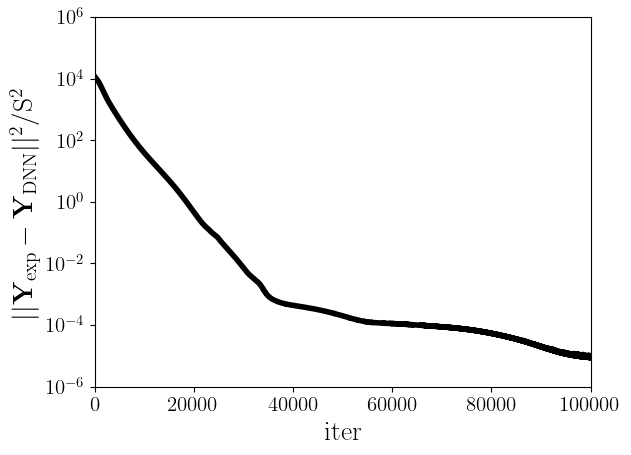

In [18]:
plt.semilogy(np.asarray(loss_vec)[:,0], np.asarray(loss_vec)[:,1], linewidth=4, color="black")

plt.xlim(0, 1E5)
plt.ylim(1E-6, 1E6)
plt.xlabel(r'iter', fontsize=20)
plt.ylabel(r'$|| \mathbf Y_{\rm exp} - \mathbf Y_{\rm DNN} ||^{2}/\rm S^{2}$', fontsize=20)
plt.show()

# 4. Recover the DCTs and admittances

## 4.1 Outputs of the DNNs

In [19]:
for index in range(N_temps):
    
    # real and imaginary parts of the DNN-regressed admittance
    gamma = gamma_NN_output[index*N_taus:(index+1)*N_taus]
    G_inf = YC_NN_output[index, 0]
    C_0 = YC_NN_output[index, 1]
    Y_re_DNN = (G_inf + torch.matmul(A_re_torch, gamma)).detach().cpu().numpy()
    Y_im_DNN = (2.*np.pi*freq_times_Cref_torch*C_0 + torch.matmul(A_im_torch, gamma)).detach().cpu().numpy()
    
    # DNN-regressed DCT
    gamma_DCT_DNN = gamma_NN_output[index*N_taus:(index+1)*N_taus].detach().cpu().numpy().reshape(N_taus)

# DNN-regressed admittance
Y_DNN = Y_re_DNN + 1j*Y_im_DNN

# DNN-regressed impedance
Z_DNN = 1/Y_DNN

## 4.2 Nyquist plot of the experimental, exact, and DNN-regressed impedances (Figure 8 (a))

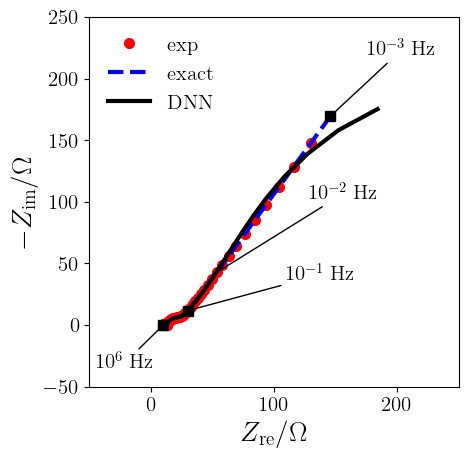

In [20]:
plt.plot(np.real(Z_exp_list[0]), -np.imag(Z_exp_list[0]), 'o', markersize=7, color='red', label='exp')
plt.plot(np.real(Z_exact), -np.imag(Z_exact), '--', linewidth=3, color='blue', label='exact')
plt.plot(np.real(Z_DNN), -np.imag(Z_DNN), linewidth=3, color='black', label='DNN')
plt.plot(np.real(Z_exp_list[0][0]), -np.imag(Z_exp_list[0][0]), 's', markersize=7, color='black')
plt.plot(np.real(Z_exp_list[0][20]), -np.imag(Z_exp_list[0][20]), 's', markersize=7, color='black')
plt.plot(np.real(Z_exp_list[0][90]), -np.imag(Z_exp_list[0][90]), 's', markersize=7, color='black')

plt.annotate(r'$10^{-3} \; \rm{Hz}$', xy=(np.real(Z_exp[0]), -np.imag(Z_exp[0])), 
                 xytext=(np.real(Z_exp[0])+30, 50-np.imag(Z_exp[0])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{-2} \; \rm{Hz}$', xy=(np.real(Z_exp[10]), -np.imag(Z_exp[10])), 
                 xytext=(np.real(Z_exp[10])+75, 60-np.imag(Z_exp[10])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{-1} \; \rm{Hz}$', xy=(np.real(Z_exp[20]), -np.imag(Z_exp[20])), 
                 xytext=(np.real(Z_exp[20])+80, 25-np.imag(Z_exp[20])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{6} \; \rm{Hz}$', xy=(np.real(Z_exp[90]), -np.imag(Z_exp[90])), 
                 xytext=(np.real(Z_exp[90])-55, -35-np.imag(Z_exp[90])), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))

plt.axis('scaled')
plt.xlim(-50, 250)
plt.ylim(-50, 250)
plt.legend(frameon=False, fontsize = 15, loc='upper left')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()

## 4.3 Nyquist plot of the experimental, exact, and DNN-regressed admittances (Figure 8 (b))

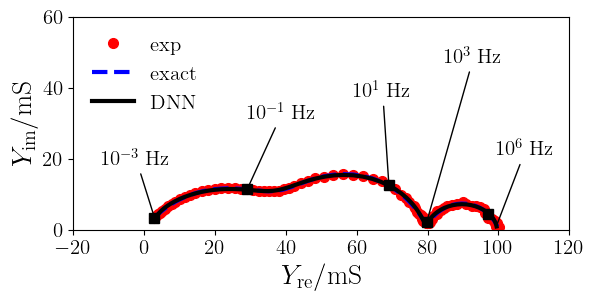

In [21]:
plt.plot(np.real(1/Z_exp_list[0]*1000), np.imag(1/Z_exp_list[0]*1000), 'o', markersize=7, color='red', label='exp')
plt.plot(np.real(Y_exact*1000), np.imag(Y_exact*1000), '--', linewidth=3, color='blue', label='exact')
plt.plot(np.real(Y_DNN*1000), np.imag(Y_DNN*1000), linewidth=3, color='black', label='DNN')
plt.plot(np.real(Y_exp[0]*1000), np.imag(Y_exp[0]*1000), 's', markersize=7, color='black')
plt.plot(np.real(Y_exp[20]*1000), np.imag(Y_exp[20]*1000), 's', markersize=7, color='black')
plt.plot(np.real(Y_exp[40]*1000), np.imag(Y_exp[40]*1000), 's', markersize=7, color='black')
plt.plot(np.real(Y_exp[60]*1000), np.imag(Y_exp[60]*1000), 's', markersize=7, color='black')
plt.plot(np.real(Y_exp[80]*1000), np.imag(Y_exp[80]*1000), 's', markersize=7, color='black')

plt.annotate(r'$10^{-3} \; \rm{Hz}$', xy=(np.real(Y_exp[0]*1000), np.imag(Y_exp[0]*1000)), 
                 xytext=(np.real(Y_exp[0]*1000)-15, 15+np.imag(Y_exp[0]*1000)), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{-1} \; \rm{Hz}$', xy=(np.real(Y_exp[20]*1000), np.imag(Y_exp[20]*1000)), 
                 xytext=(np.real(Y_exp[20]*1000), 20+np.imag(Y_exp[20]*1000)), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{1} \; \rm{Hz}$', xy=(np.real(Y_exp[40]*1000), np.imag(Y_exp[40]*1000)), 
                 xytext=(np.real(Y_exp[40]*1000)-10, 25+np.imag(Y_exp[40]*1000)), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{3} \; \rm{Hz}$', xy=(np.real(Y_exp[60]*1000), np.imag(Y_exp[60]*1000)), 
                 xytext=(np.real(Y_exp[60]*1000)+5, 45+np.imag(Y_exp[60]*1000)), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{6} \; \rm{Hz}$', xy=(np.real(Y_exp[90]*1000), np.imag(Y_exp[90]*1000)), 
                 xytext=(np.real(Y_exp[90]*1000), 20+np.imag(Y_exp[90]*1000)), 
                 arrowprops=dict(arrowstyle="-", connectionstyle="arc"))

plt.axis('scaled')
plt.xlim(-20, 120)
plt.ylim(0, 60)
plt.legend(frameon=False, fontsize = 15, loc='upper left')
plt.xlabel(r'$Y_{\rm re}/\rm mS$', fontsize = 20)
plt.ylabel(r'$Y_{\rm im}/\rm mS$', fontsize = 20)
plt.show()

## 4.4 Plot of the exact and DNN-regressed DCTs (Figure 8 (c))

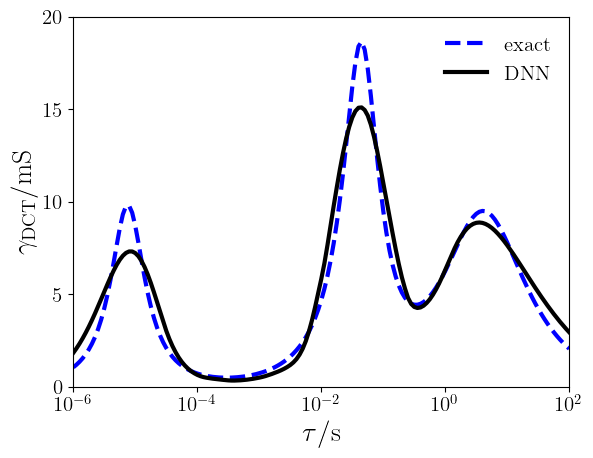

In [22]:
plt.semilogx(tau_vec, gamma_DCT_exact*1000, '--', linewidth=3, color='blue', label='exact')
plt.semilogx(tau_vec, gamma_DCT_DNN*1000, linewidth=3, color='black', label='DNN')

plt.xlim(1E-6, 1E2)
plt.ylim(0, 20)
plt.yticks(np.arange(0, 20.01, 5))
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$\tau/\rm s$', fontsize = 20) 
plt.ylabel(r'$\gamma_{\rm DCT}/\rm mS$', fontsize = 20)
plt.show()

## 4.5 Bode plots of the experimental, exact and DNN-regressed impedances (Figure 8 (d))

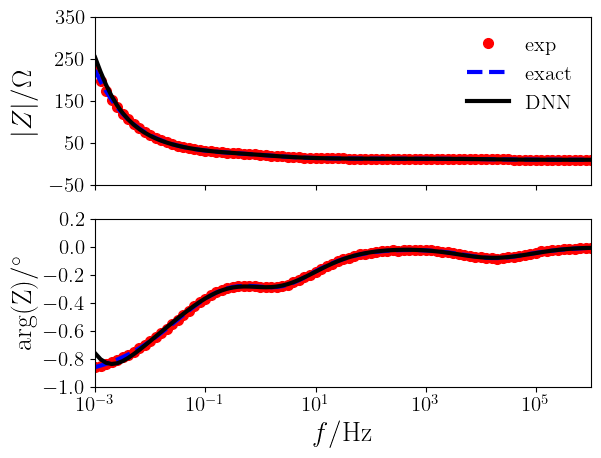

In [23]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.semilogx(freq_vec, np.abs(Z_exp), 'o', markersize=7, color='red', label='exp')
ax1.semilogx(freq_vec, np.abs(Z_exact), '--', linewidth=3, color='blue', label='exact')
ax1.semilogx(freq_vec, np.abs(Z_DNN), linewidth=3, color='black', label='DNN')
ax1.axis([1E-3, 1E6, -50, 350])
ax1.set_yticks(np.arange(-50, 350.01, step=100)) 
ax1.legend(frameon=False, fontsize = 15)
ax1.set_ylabel(r'$| Z |/\Omega$', fontsize = 20)

ax2.semilogx(freq_vec, np.angle(Z_exp), 'o', markersize=7, color='red', label='exp')
ax2.semilogx(freq_vec, np.angle(Z_exact), '--', linewidth=3, color='blue', label='exact')
ax2.semilogx(freq_vec, np.angle(Z_DNN), linewidth=3, color='black', label='DNN')
ax2.axis([1E-3, 1E6, -1, 0.2])
ax2.set_yticks(np.arange(-1, 0.201, step=0.2))
ax2.set_ylabel(r'$\rm arg(Z)/^\circ$', fontsize = 20)

plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
fig.align_ylabels()
plt.show()

## 4.6 Bode plots of the experimental, exact and DNN-regressed admittances (Figure S11 (a) in the Supplementary Information Part 2)

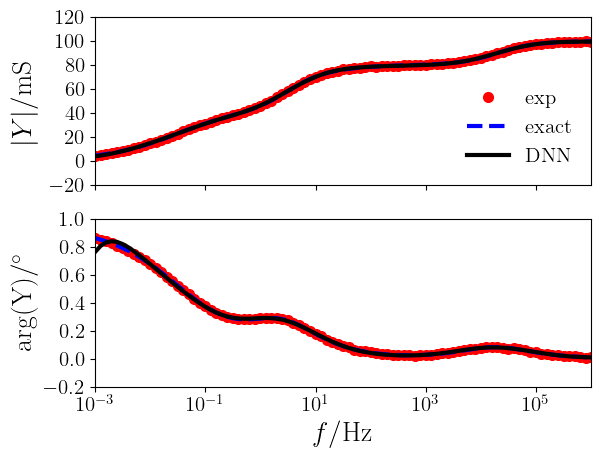

In [24]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.semilogx(freq_vec, np.abs(Y_exp)*1000, 'o', markersize=7, color='red', label='exp')
ax1.semilogx(freq_vec, np.abs(Y_exact)*1000, '--', linewidth=3, color='blue', label='exact')
ax1.semilogx(freq_vec, np.abs(Y_DNN)*1000, linewidth=3, color='black', label='DNN')
ax1.set_ylabel(r'$| Y |/\rm mS$', fontsize = 20)
ax1.axis([1E-3, 1E6, -20, 120])
ax1.legend(frameon=False, fontsize = 15, loc='lower right')
ax1.set_yticks(np.arange(-20, 120.01, step=20)) 

ax2.semilogx(freq_vec, np.angle(Y_exp), 'o', markersize=7, color='red', label='exp')
ax2.semilogx(freq_vec, np.angle(Y_exact), '--', linewidth=3, color='blue', label='exact')
ax2.semilogx(freq_vec, np.angle(Y_DNN), linewidth=3, color='black', label='DNN')
ax2.set_ylabel(r'$\rm arg(Y)/^\circ$', fontsize = 20)
ax2.axis([1E-3, 1E6, -0.2, 1.])
ax2.set_yticks(np.arange(-0.2, 1.001, step=0.2)) 

plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
fig.align_ylabels()
plt.show()

# 5. Peak separation of the recovered DCT (Figure 8 (e))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0030401952017887236
            Iterations: 2
            Function evaluations: 9
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.000971330976229668
            Iterations: 10
            Function evaluations: 42
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.132603363389173e-05
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.0693804574616536e-05
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2


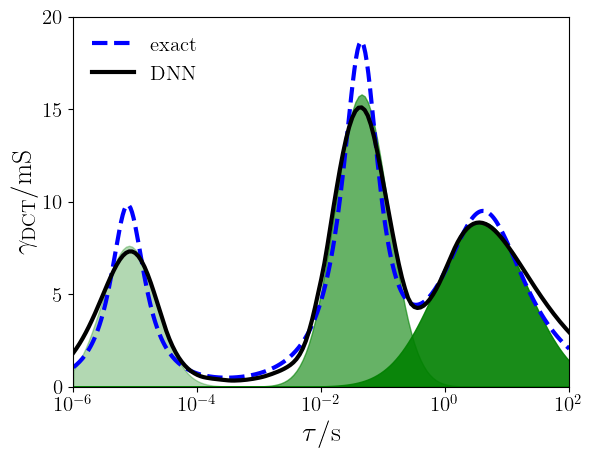

In [25]:
# separate the peaks of the DNN-regressed DCT
gamma_fit = compute_DCT.peak_analysis_Gauss(tau_vec, gamma_DCT_DNN, N_peaks=3, method = 'separate')[0]

# plot
tau_vec_plot = np.logspace(-6, 2, num = 322, endpoint=True)
gamma_DCT_plot = gamma_DCT_exact_fct(tau_vec_plot, R_inf, R_ct_1, tau_1, phi_1, R_ct_2, tau_2, phi_2, A, alpha)

plt.semilogx(tau_vec_plot, gamma_DCT_plot*1000, '--', color='blue', linewidth=3, label='exact')
plt.semilogx(tau_vec, gamma_DCT_DNN*1000, color='black', linewidth=3, label='DNN')
plt.fill_between(tau_vec, gamma_fit[0]*1000, color='green', alpha=0.6)
plt.fill_between(tau_vec, gamma_fit[1]*1000, color='green', alpha=0.9)
plt.fill_between(tau_vec, gamma_fit[2]*1000, color='green', alpha=0.3)

plt.xlim(1E-6, 1E2)
plt.ylim(0, 20)
plt.yticks(np.arange(0, 20.01, 5))
plt.legend(frameon=False, fontsize = 15, loc='upper left')
plt.xlabel(r'$\tau/\rm s$', fontsize=20)
plt.ylabel(r'$\gamma_{\rm DCT}/\rm mS$', fontsize=20)
plt.show()